# EVALUACIÓN DE ETIQUETADORES MORFOSINTÁCTICOS PARA EL ESPAÑOL

In [4]:
import nltk
from nltk.corpus import cess_esp as cess
from nltk.tag import hmm
from nltk.tag import tnt
from nltk.tag.sequential import AffixTagger
from nltk.tag import brill, BigramTagger, BrillTaggerTrainer, CRFTagger, RegexpTagger, UnigramTagger
from nltk.tag.perceptron import PerceptronTagger
nltk.download('cess_esp')

import matplotlib.pyplot as plt

import numpy as np
from numpy import mean
from numpy import std

import scipy as sp
import scipy.stats

import inspect
import random
import time

import sklearn
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

!pip3 install sklearn_crfsuite
!pip install python-crfsuite
!pip install pythainlp

[nltk_data] Downloading package cess_esp to /root/nltk_data...
[nltk_data]   Package cess_esp is already up-to-date!


1.**Objetivos del trabajo:**

* Conocer distintas herramientas de etiquetado morfosintáctico del paquete NLTK
* Aplicar   la   metodología   de   validación   cruzada   para   entrenar   y   evaluar etiquetadores morfosintácticos.
* Construir modelos de etiquetado morfosintáctico para el español a partir de corpus anotados
* Comparar las prestaciones de distintos etiquetadores incluyendointervalos de confianza

2.**Descripción del trabajo:**

El trabajo consiste  en  la  evaluación  de  las  prestaciones  dedistintosetiquetadores  morfosintácticos para uncorpus  del español(cess-esp).  En  esta  experimentación  se  estudiará  cómo  afectan  diversos parámetros  a  las  prestaciones  del  sistema:  el  tamaño  del  corpus  de  entrenamiento,  el  método  de suavizado para las palabras desconocidas, el juego de categorías morfosintácticas utilizado, etc.

Además,  se  compararán  las  prestaciones  de  distintos  etiquetadores  morfosintácticos  basados  en distintos paradigmas de aprendizaje.

Para ello,se utilizará el paquete NLTKque implementa diferentes etiquetadores morfosintácticos.

La evaluación de los etiquetadores se realizará mediante una validación cruzadasobre 10 partidoes del corpus.  Esta metodología consiste en dividir el corpus en 10 partes de similar tamaño, y ejecutar diez  experimentos.

En cada ejecución se  toman  9  partes  como  entrenamiento  y  1  como  prueba,  de manera que la parte de prueba siempre sea diferente.

La evaluación de las prestaciones del etiquetador es el resultado de calcular la media de la precisión de etiquetado (accuracy) sobre las distintas partidoes.

accuracy= número palabras etiquetadas correctamentedel test/ número total de palabrasdel test

IMPORTANTE:   Los   resultados   de accuracyobtenidos   deberán   presentarse   siempre   con el correspondiente intervalode confianza

## Funciones

In [5]:
def label_transform (lista):
    for position, item in enumerate(lista):
        if item[1].startswith('v') or item[1].startswith('F'):
            lista[position] = ( lista[position][0], item[1][:3] ) 
        else:
            lista[position] = ( lista[position][0] , item[1][:2] )
    return lista
    

def eliminarAnotaciones(lista):
    for idx,tagged_word in enumerate(lista):
        if tagged_word[0] == '*0*' or tagged_word[0] == 'sn':
            lista.pop(idx)
        else:
            pass
    
    return label_transform(lista)

def validacion_cruzada(classificador,train_data,k):
    kf = KFold(k,shuffle=True)
    scores=[]
  
    for i,j in kf.split(train_data):
        if type(classificador) == type(hmm.HiddenMarkovModelTrainer()):
            model = classificador.train_supervised(train_data[i[0]:i[-1]])
            scores.append(model.evaluate(train_data[j[0]:j[-1]]))
        else:
            classificador.train(train_data[i[0]:i[-1]])
            scores.append(classificador.evaluate(train_data[j[0]:j[-1]]))
    
    return scores

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * sp.stats.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h,h

### Corpus

In [6]:
oraciones_sin_procesar = cess.tagged_sents()
oraciones_sin_procesar

[[('El', 'da0ms0'), ('grupo', 'ncms000'), ('estatal', 'aq0cs0'), ('Electricité_de_France', 'np00000'), ('-Fpa-', 'Fpa'), ('EDF', 'np00000'), ('-Fpt-', 'Fpt'), ('anunció', 'vmis3s0'), ('hoy', 'rg'), (',', 'Fc'), ('jueves', 'W'), (',', 'Fc'), ('la', 'da0fs0'), ('compra', 'ncfs000'), ('del', 'spcms'), ('51_por_ciento', 'Zp'), ('de', 'sps00'), ('la', 'da0fs0'), ('empresa', 'ncfs000'), ('mexicana', 'aq0fs0'), ('Electricidad_Águila_de_Altamira', 'np00000'), ('-Fpa-', 'Fpa'), ('EAA', 'np00000'), ('-Fpt-', 'Fpt'), (',', 'Fc'), ('creada', 'aq0fsp'), ('por', 'sps00'), ('el', 'da0ms0'), ('japonés', 'aq0ms0'), ('Mitsubishi_Corporation', 'np00000'), ('para', 'sps00'), ('poner_en_marcha', 'vmn0000'), ('una', 'di0fs0'), ('central', 'ncfs000'), ('de', 'sps00'), ('gas', 'ncms000'), ('de', 'sps00'), ('495', 'Z'), ('megavatios', 'ncmp000'), ('.', 'Fp')], [('Una', 'di0fs0'), ('portavoz', 'nccs000'), ('de', 'sps00'), ('EDF', 'np00000'), ('explicó', 'vmis3s0'), ('a', 'sps00'), ('EFE', 'np00000'), ('que', 'c

In [7]:
oraciones_procesadas = []

for i in oraciones_sin_procesar:
    procesada = eliminarAnotaciones(i)
    oraciones_procesadas.append(procesada)
    
oraciones_procesadas

[[('El', 'da'),
  ('grupo', 'nc'),
  ('estatal', 'aq'),
  ('Electricité_de_France', 'np'),
  ('-Fpa-', 'Fpa'),
  ('EDF', 'np'),
  ('-Fpt-', 'Fpt'),
  ('anunció', 'vmi'),
  ('hoy', 'rg'),
  (',', 'Fc'),
  ('jueves', 'W'),
  (',', 'Fc'),
  ('la', 'da'),
  ('compra', 'nc'),
  ('del', 'sp'),
  ('51_por_ciento', 'Zp'),
  ('de', 'sp'),
  ('la', 'da'),
  ('empresa', 'nc'),
  ('mexicana', 'aq'),
  ('Electricidad_Águila_de_Altamira', 'np'),
  ('-Fpa-', 'Fpa'),
  ('EAA', 'np'),
  ('-Fpt-', 'Fpt'),
  (',', 'Fc'),
  ('creada', 'aq'),
  ('por', 'sp'),
  ('el', 'da'),
  ('japonés', 'aq'),
  ('Mitsubishi_Corporation', 'np'),
  ('para', 'sp'),
  ('poner_en_marcha', 'vmn'),
  ('una', 'di'),
  ('central', 'nc'),
  ('de', 'sp'),
  ('gas', 'nc'),
  ('de', 'sp'),
  ('495', 'Z'),
  ('megavatios', 'nc'),
  ('.', 'Fp')],
 [('Una', 'di'),
  ('portavoz', 'nc'),
  ('de', 'sp'),
  ('EDF', 'np'),
  ('explicó', 'vmi'),
  ('a', 'sp'),
  ('EFE', 'np'),
  ('que', 'cs'),
  ('el', 'da'),
  ('proyecto', 'nc'),
  ('para',

In [8]:
train_completo, test_completo = train_test_split(oraciones_sin_procesar, test_size=0.10, random_state=42)
train_reducido, test_reducido = train_test_split(oraciones_procesadas, test_size=0.10, random_state=42)

# Tarea 1:

#### Evaluación del etiquetador ‘hmm’ sobre el corpus ‘cess-esp’ utilizando el juego de categorías completo y reducido.

Utilizando el etiquetador hmm basado en modelos de Markov, se realizará una validación cruzada sobre 10 partidoes del corpus. Barajar el corpus antes de realizar las partidoes. Presentar los resultados en forma de tabla y gráficamente, incluyendo los intervalos de confianza.

In [6]:
modelo = hmm.HiddenMarkovModelTrainer()
accuracys_completo = validacion_cruzada(modelo, list(oraciones_sin_procesar), k=10)

In [7]:
accuracys_reducido = validacion_cruzada(modelo, oraciones_procesadas, k=10)

In [8]:
print('A. Completo: ',mean_confidence_interval(accuracys_completo))
print('A. Reducido: ',mean_confidence_interval(accuracys_reducido))

A. Completo:  (0.9842090332846933, 0.98409069334463, 0.9843273732247567, 0.00011833994006334979)
A. Reducido:  (0.9889184590240452, 0.9888003696743044, 0.989036548373786, 0.00011808934974072503)


In [19]:
print(accuracys_completo)

[0.984263935530707, 0.984262533804868, 0.984250249500998, 0.9842697921458743, 0.9842653791465492, 0.9842658072052902, 0.9842644121190627, 0.9842469148686374, 0.983738655479637, 0.9842626530453092]


In [20]:
print(accuracys_reducido)

[0.9889695919917962, 0.9889620366616163, 0.9889835925847006, 0.9889662594500711, 0.9889534233740238, 0.9889901898059288, 0.9889727559080214, 0.9889638749773084, 0.9889732686914271, 0.9884495967955579]


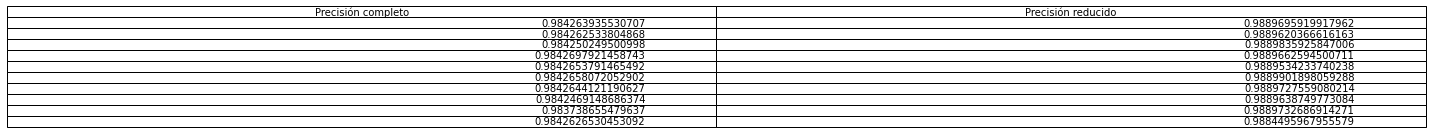

In [21]:
fig, ax = plt.subplots(figsize=(20,2))

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=np.array( [accuracys_completo, accuracys_reducido ] ).T, colLabels=["Precisión completo","Precisión reducido"], loc='center')

fig.tight_layout()

plt.show()

In [22]:
_, _, _, err_completo = mean_confidence_interval(accuracys_completo[1:])
_, _, _, err_reducido = mean_confidence_interval(accuracys_reducido[1:])

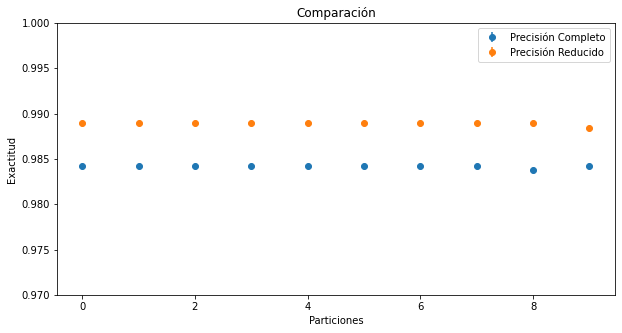

In [25]:
plt.figure(figsize=(10,5))
plt.errorbar(range(10), accuracys_completo,yerr=err_completo, fmt='o', label='Precisión Completo')
plt.errorbar(range(10), accuracys_reducido,yerr=err_reducido, fmt='o', label='Precisión Reducido')
plt.ylim(0.97, 1)
plt.title('Comparación')
plt.xlabel('Particiones')
plt.ylabel('Exactitud')
plt.legend()
plt.show()

# Tarea 2:

#### Evaluación de las prestaciones del etiquetador respecto a la cantidad de datos de aprendizaje.

Se trata de estudiar cómo varían las prestaciones del etiquetador hmm cuando varía el tamaño del corpus de aprendizaje. Para este experimento se dividirá el corpus de entrenamiento en 10 partes de tamaño similar. La partición 10 se tomará como test, y las 9 partidoes restantes se tomarán como entrenamiento. En cada ejecución, se irá incrementando sucesivamente el tamaño del corpus de entrenamiento, manteniendo fija la partición de test.

> **Importante:** Para esta tarea **no es necesario** realizar la validación cruzada.

Entre 0 y  5990  Exactitud:  0.9829727776951357
Entre 0 y  12012  Exactitud:  0.988572369679325
Entre 0 y  18033  Exactitud:  0.9887423762670804
Entre 0 y  24027  Exactitud:  0.9887476889729477
Entre 0 y  30028  Exactitud:  0.9887476889729477
Entre 0 y  36041  Exactitud:  0.9887530016788151
Entre 0 y  42037  Exactitud:  0.9889708226193765
Entre 0 y  48053  Exactitud:  0.9889708226193765
Entre 0 y  54076  Exactitud:  0.9889867607369786


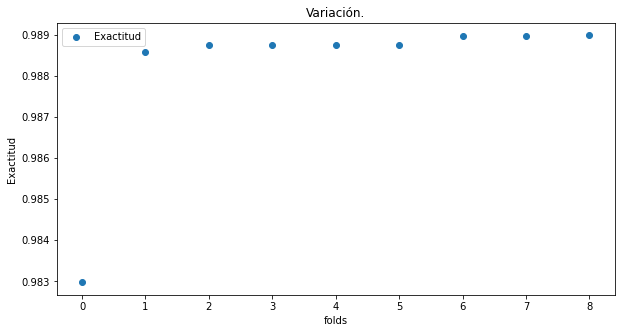

In [26]:
trainers = []

acc = []
tmp = []

kf = KFold(n_splits=10,shuffle=True)
for _, j in  kf.split(oraciones_procesadas):
    trainers.append(oraciones_procesadas[j[0]:j[-1]])

for idx,i in enumerate(trainers[:9]):
    tmp += i
    model = modelo.train_supervised(tmp)
    acc.append(model.evaluate(trainers[-1]))
    print("Entre 0 y ",len(tmp) - 1," Exactitud: ",acc[idx])


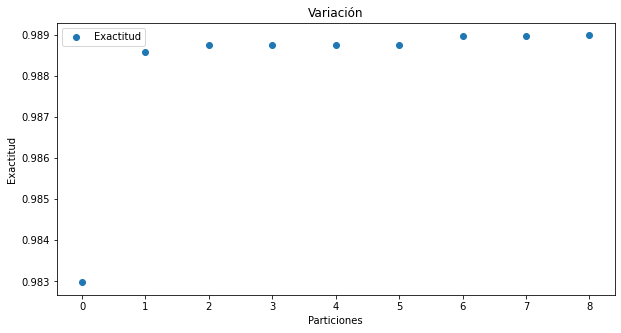

In [28]:
plt.figure(figsize=(10,5))
plt.plot(range(9), acc, 'o', label='Exactitud')
plt.title('Variación')
plt.xlabel('Particiones')
plt.ylabel('Exactitud')
plt.legend()
plt.show()

# Tarea 3:

#### Evaluación del método de suavizado para palabras desconocidas para el etiquetador tnt.

El etiquetador tnt por defecto no incorpora un método de suavizado para las palabras desconocidas. Utiliza un método basado en los sufijos de las palabras para construir un modelo para las palabras desconocidas (Affix Tagger). En base al sufijo de la palabra desconocida le asigna una categoría morfosintáctica. Este método funciona razonablemente bien para el inglés.

En concreto, se trata de estudiar diferentes longitudes del sufijo (número de letras que se tienen en cuenta) y estudiar cómo varían las prestaciones del etiquetador. Una vez se haya decidido el sufijo que mejores prestaciones proporciona, incorporarlo como modelo de suavizado al etiquetador tnt y comprobar si aumenta sus prestaciones.

In [29]:
accuracys = []
accuracysSolo = []

In [30]:
for i in range(-1,-5,-1):
    #SIN TNT
    affix_tagger = AffixTagger(train=train_reducido,affix_length=i)
    evalSolo = affix_tagger.evaluate(test_reducido)
    accuracysSolo.append(evalSolo)
    print("Suavizado Solo con  Affix_Length = ",i," Accuracy: ", evalSolo)

    #CON TNT
    tnt_tagging =  tnt.TnT(unk=affix_tagger,Trained=True)
    tnt_tagging.train(train_reducido)
    evaluacion = tnt_tagging.evaluate(test_reducido)
    accuracys.append(evaluacion)
    print("TnT Con suavizado Affix_Length = ",i," Accuracy: ", evaluacion)

Suavizado Solo con  Affix_Length =  -1  Accuracy:  0.24165070159995858
TnT Con suavizado Affix_Length =  -1  Accuracy:  0.9249210376430383
Suavizado Solo con  Affix_Length =  -2  Accuracy:  0.2774297105576555
TnT Con suavizado Affix_Length =  -2  Accuracy:  0.936260549888676
Suavizado Solo con  Affix_Length =  -3  Accuracy:  0.2908921451871796
TnT Con suavizado Affix_Length =  -3  Accuracy:  0.9460467042924455
Suavizado Solo con  Affix_Length =  -4  Accuracy:  0.26215502511261846
TnT Con suavizado Affix_Length =  -4  Accuracy:  0.9435613317454564


In [34]:
print(accuracys)

[0.9249210376430383, 0.936260549888676, 0.9460467042924455, 0.9435613317454564]


In [36]:
print(accuracysSolo)

[0.24165070159995858, 0.2774297105576555, 0.2908921451871796, 0.26215502511261846]


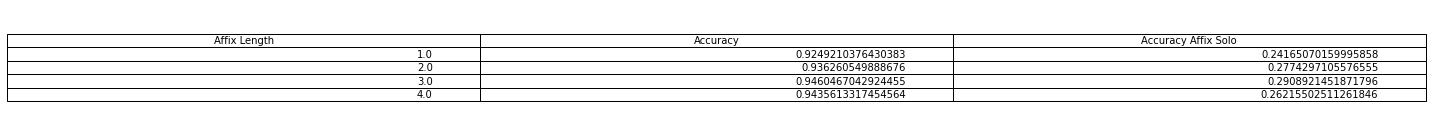

In [31]:
fig, ax = plt.subplots(figsize=(20,2))

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=np.array([range(1,5),accuracys,accuracysSolo]).T, colLabels=["Affix Length","Accuracy","Accuracy Affix Solo"], loc='center')

fig.tight_layout()

plt.show()

# Tarea 4:

#### Evaluación del resto de etiquetadores.

Se deberán utilizar otros paradigmas de etiquetado. Como mínimo el etiquetador de Brill y algún otro como, CRF, perceptron. Se deberá realizar una comparativa de prestaciones respecto a los etiquetadores tnt y hmm, utilizando el juego de categorías reducido.

Cuando se utilice el etiquetador de Brill, probar con diferentes etiquetados iniciales, por ejemplo probar con Unigram Tagger y con hmm tagger.

La comparación puede ser sólo de una partición, si el coste temporal de la validación cruzada requiere mucho tiempo.

In [9]:
# inicializamos una lista vacia que contendra los nombres de los modelos para un diagrama de barras.
xlabels = []

# inicializamos una lista vacia que contendrá las preciciones de los modelos.
accuracys = []

In [ ]:
# definimos un método para entrenar el modelo brill con el tagger especificado.
def entrenar_bill(initial_tagger,tagger_name):
    brill_tagger = BrillTaggerTrainer(initial_tagger=initial_tagger,templates=brill.brill24())
    tagger1 = brill_tagger.train(train_reducido[:1000])
    evaluacion = tagger1.evaluate(test_reducido[:1000])
    xlabels.append("Brill Tagger "+tagger_name)
    accuracys.append(evaluacion)

In [ ]:
# instanciamos y entrenamos brill con el tagger Regexp basado en el ejemplo de uso del mismo.
tagger = RegexpTagger([
(r'^-?[0-9]+(.[0-9]+)?$', 'CD'),   # cardinal numbers
(r'(The|the|A|a|An|an)$', 'AT'),   # articles
(r'.*able$', 'JJ'),                # adjectives
(r'.*ness$', 'NN'),                # nouns formed from adjectives
(r'.*ly$', 'RB'),                  # adverbs
(r'.*s$', 'NNS'),                  # plural nouns
(r'.*ing$', 'VBG'),                # gerunds
(r'.*ed$', 'VBD'),                 # past tense verbs
(r'.*', 'NN')                      # nouns (default)
])
entrenar_bill(tagger,"RegexpTagger")

In [ ]:
# instanciamos y entrenamos brill con el tagger Unigram.
tagger = UnigramTagger(train_reducido[:1000])
tagger.evaluate(test_reducido[:1000])
entrenar_bill(tagger,"UnigramTagger")

In [ ]:
# instanciamos y entrenamos brill con el tagger Bigram.
tagger = BigramTagger(train_reducido[:1000])
tagger.evaluate(test_reducido[:1000])
entrenar_bill(tagger,"BigramTagger")

In [ ]:
# instanciamos, entrenamos y evaluamos el modelo CRF Tagger.
ct = CRFTagger()
ct.train(train_reducido[:1000],'model.crf.tagger')
evaluacion = ct.evaluate(test_reducido[:1000])
xlabels.append("CRF Tagger")
accuracys.append(evaluacion)

In [ ]:
# instanciamos, entrenamos y evaluamos el modelo Perceptron Tagger.
tagger = PerceptronTagger(load=False)
tagger.train(train_reducido[:1000])
evaluacion = tagger.evaluate(test_reducido[:1000])
xlabels.append("Perceptron Tagger")
accuracys.append(evaluacion)

In [ ]:
print(accuracys)

In [ ]:
print(xlabels)

In [ ]:
fig, ax = plt.subplots(figsize=(20,2))

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=[accuracys], colLabels=xlabels, loc='center')

fig.tight_layout()

plt.show()

In [10]:
fig, ax = plt.subplots(figsize=(20,2))

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=[accuracys], colLabels=xlabels, loc='center')

fig.tight_layout()

plt.show()

In [11]:
# instanciamos y entrenamos brill con el tagger Regexp basado en el ejemplo de uso del mismo.
tagger = RegexpTagger([
(r'^-?[0-9]+(.[0-9]+)?$', 'CD'),   # cardinal numbers
(r'(The|the|A|a|An|an)$', 'AT'),   # articles
(r'.*able$', 'JJ'),                # adjectives
(r'.*ness$', 'NN'),                # nouns formed from adjectives
(r'.*ly$', 'RB'),                  # adverbs
(r'.*s$', 'NNS'),                  # plural nouns
(r'.*ing$', 'VBG'),                # gerunds
(r'.*ed$', 'VBD'),                 # past tense verbs
(r'.*', 'NN')                      # nouns (default)
])
entrenar_bill(tagger,"RegexpTagger")

In [12]:
# instanciamos y entrenamos brill con el tagger Unigram.
tagger = UnigramTagger(train_reducido[:1000])
tagger.evaluate(test_reducido[:1000])
entrenar_bill(tagger,"UnigramTagger")

In [13]:
# instanciamos y entrenamos brill con el tagger Bigram.
tagger = BigramTagger(train_reducido[:1000])
tagger.evaluate(test_reducido[:1000])
entrenar_bill(tagger,"BigramTagger")

In [14]:
# instanciamos, entrenamos y evaluamos el modelo CRF Tagger.
ct = CRFTagger()
ct.train(train_reducido[:1000],'model.crf.tagger')
evaluacion = ct.evaluate(test_reducido[:1000])
xlabels.append("CRF Tagger")
accuracys.append(evaluacion)

In [15]:
# instanciamos, entrenamos y evaluamos el modelo Perceptron Tagger.
tagger = PerceptronTagger(load=False)
tagger.train(train_reducido[:1000])
evaluacion = tagger.evaluate(test_reducido[:1000])
xlabels.append("Perceptron Tagger")
accuracys.append(evaluacion)

In [17]:
print(accuracys)

[0.7299228498938539, 0.7922124993527676, 0.7130948066069487, 0.920157406927976, 0.9387977010303941]


In [18]:
print(xlabels)

['Brill Tagger RegexpTagger', 'Brill Tagger UnigramTagger', 'Brill Tagger BigramTagger', 'CRF Tagger', 'Perceptron Tagger']


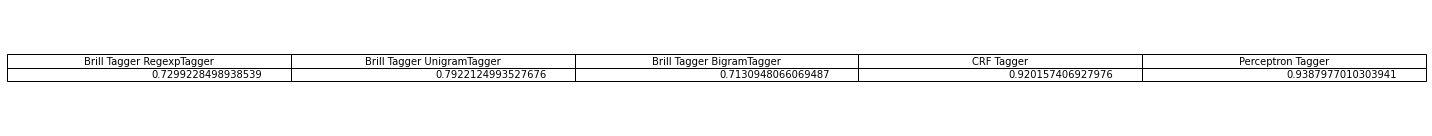

In [19]:
fig, ax = plt.subplots(figsize=(20,2))

fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

ax.table(cellText=[accuracys], colLabels=xlabels, loc='center')

fig.tight_layout()

plt.show()